<center> <h5>Wintersemester 2024/25</h5> </center>
<center> <h1>Medizinische Bildanalyse</h1> </center>
<center> <h3>Aufgabenblatt 10</h3> </center>
<center> <h5>16. Dezember 2024</h5> </center>
<center> <h5>
    Prof. Dr. Thomas Schultz, 
    <a href = "mailto: jlen@uni-bonn.de">Jonathan Lennartz</a>,
    <a href = "mailto: jgruen@uni-bonn.de">Dr. Johannes Grün</a>
</h5> </center>
<center> <h5>Abgabefrist: <b>07.01.2025, 10:00 Uhr, via eCampus</b></h5> </center>
</br>


### Aufgabe 1 (Berechnung einer  Referenzform, 20 Punkte)

<table><tr>
<td> <img src="baeume-gegeben.png" alt="Gegebene Formen" style="width: 100%;"/> </td>
<td> <img src="baeume-ausgerichtet.png" alt="Ausgerichtete Formen" style="width: 100%;"/> </td>
</tr></table>
<center>Abbildung: Die gegeben Formen (links) und das Ergebnis ihrer Ausrichtung auf die geschätzte Referenz (rechts).</center>
In dieser Aufgabe erstellen wir anhand eines kleinen Beispiels selbst eine Referenzform, mit dem Algorithmus von Folie 66. Der Jahreszeit gemäß nutzen wir hierzu vier verschiedene Weihnachtsbäume, deren Stützpunkte in der Datei `tree.npz` als 3D-Array `arr_0` der Form (4,2,16) (Bäume, x/y-Koordinaten, Stützpunkte) gegeben sind. 

a) Lest als erstes die Formen ein und plottet sie, z.B. mit `matplotlib.pyplot.plot`. Wählt das Seitenverhältnis Eures Plots so, dass die Formen unverzerrt dargestellt werden. (4P)

_Lösung:_

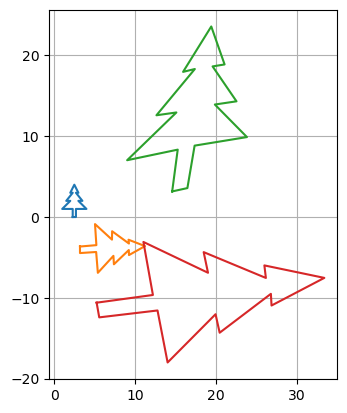

In [55]:
import matplotlib.pyplot as plt
import numpy as np

data = np.load("trees.npz")
trees = data['arr_0']

num_trees, _, n_points = trees.shape

def plot_trees(trees):
    num_trees, _, _ = trees.shape

    for t in range(num_trees):
        plt.plot(trees[t, 0, :], trees[t, 1, :])

    plt.axis("scaled")
    plt.grid(True)
    plt.show()

plot_trees(trees)

b) Schreibt nun eine Funktion, die die Formen auf den auf den Ursprung zentriert zurückgibt und plottet das Ergebnis. (3P)

_Lösung:_

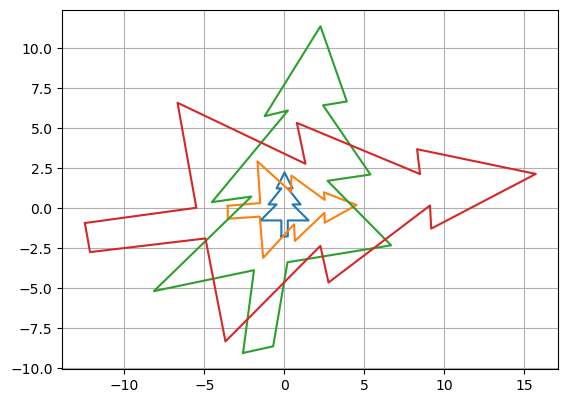

In [56]:
def center_trees(trees):
    centers = np.average(trees, axis=2)
    return trees - centers[..., None]

centered = center_trees(trees)
plot_trees(centered)

c) Schreibt eine Funktion, die die zentrierten Form normiert zurückgibt und plottet das Ergebnis. (3P)

_Lösung:_

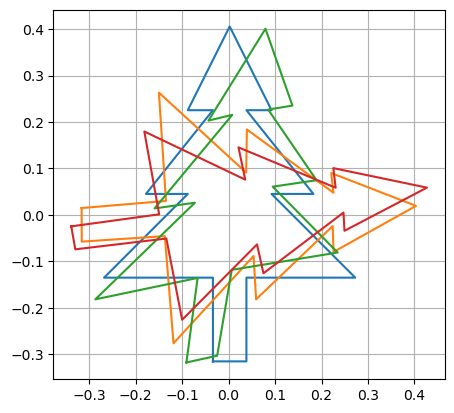

In [58]:
def scale_trees(trees):
    norms = np.linalg.norm(trees, axis=(1,2))
    return trees / norms[..., None, None]

scaled = scale_trees(centered)
plot_trees(scaled)

d) Schreibt eine Funktion, die zwei zentrierte Formen *t1, t2* als Argumente entgegennimmt, mit der Singulärwertzerlegung (Folie 64) die optimale Rotation von Form *t1* zu *t2* berechnet und die Rotationsmatrix zurückgibt. Gebt einen Fehler aus, wenn die Determinante negativ ist. Nutzt diese Funktion, um alle Weihnachtsbäume auf den ersten zu rotieren und plottet das Ergebnis. (5P)

_Lösung:_

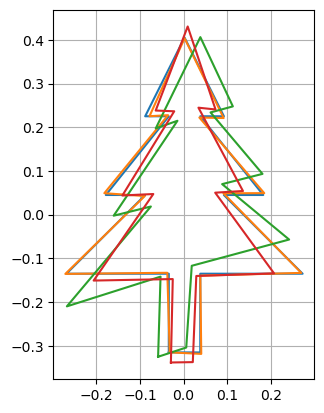

In [66]:
def optimal_rotation(t1, t2):
    W = t1 @ t2.T
    U, S, Vh = np.linalg.svd(W)
    V = np.conj(Vh.T)
    R = V @ U.T

    if np.isclose(np.linalg.det(R), -1.0):
        print("Determinant of R is -1.0")
    
    return R

def align_tree_to(tree, reference):
    R = optimal_rotation(tree, reference)
    return R @ tree

def align_trees_to(trees, reference):
    result = np.zeros_like(trees)

    for i in range(trees.shape[0]):
        result[i] = align_tree_to(trees[i], reference)

    return result

def align_trees(trees):
    return align_trees_to(trees, trees[0])

aligned = align_trees(scaled)
plot_trees(aligned)

e) Nutzt nun diese Bausteine, um den Algorithmus zur Berechnung einer Referenzform (Folie 67) zu implementieren. Im ersten Schritt zentriert ihr jede der gegebenen Formen auf den Ursprung und normiert sie. Ihr könnt davon ausgehen, dass die (zentrierte und normierte) erste Form als initiale Referenz $\bar{x}_{0}$ genutzt werden soll. Wiederholt dann die folgenden Schritte, bis $\| \bar{x}_{j+1} - \bar{x}_j \| \leq \varepsilon$:

- Richtet alle Formen an $\bar{x}_j$ aus, nennt die Resultate $x_i'$
- Berechnet $\bar{x}_{j+1} = \frac{1}{m} \sum_{i=1}^m x_i'$
- Richtet $\bar{x}_{j+1}$ an $\bar{x}_0$ aus und normiert auf $\|\bar{x}_{j+1}\|=1$

Plottet nach jedem Schritt die ausgerichteten Formen, sowie die aktuelle Referenz. (5P)

_Lösung:_

In [67]:
def plot_iteration_step(trees, reference):
    fig, axes = plt.subplots(1, 2)

    axes[0].set_title("Ausgerichtete Formen")
    for t in range(trees.shape[0]):
        axes[0].plot(trees[t, 0, :], trees[t, 1, :])
    axes[0].axis("scaled")
    axes[0].grid(True)

    axes[1].set_title("Referenzform")
    axes[1].plot(reference[0, :], reference[1, :])
    axes[1].axis("scaled")
    axes[1].grid(True)

    plt.show()

Initialisierung


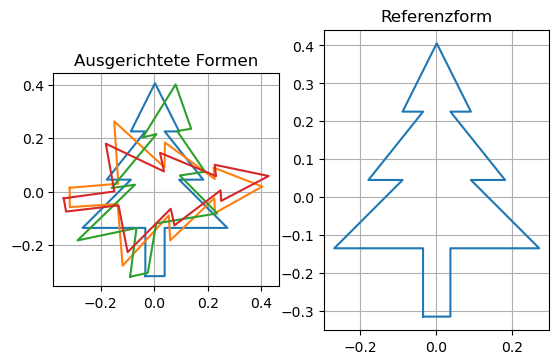

Iteration 1, Norm=0.060256416044486685


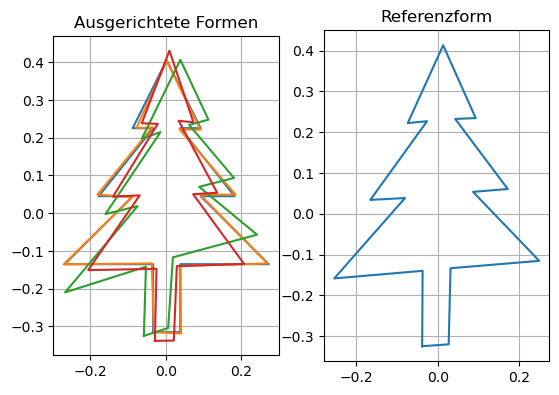

Iteration 2, Norm=0.0002405691429825213


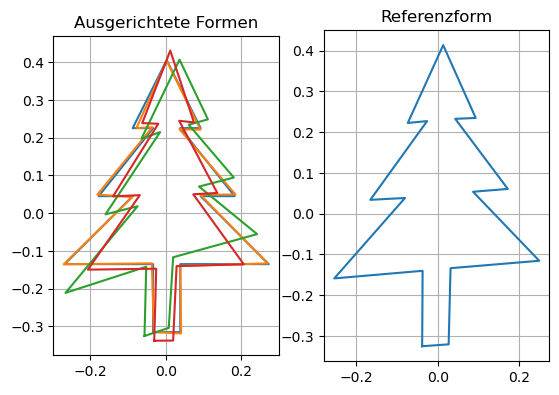

Iteration 3, Norm=1.050847356392502e-06


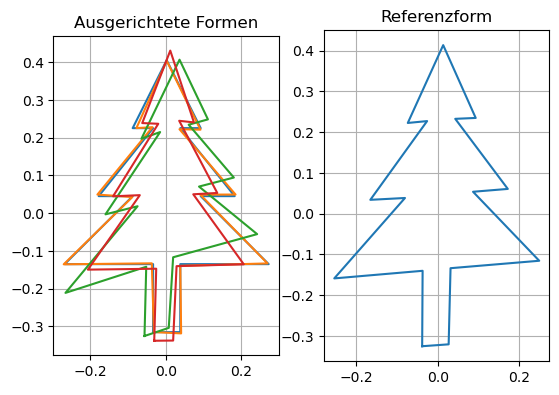

In [70]:
def referenzform(trees):
    eps = 1e-4
    
    x_i = scale_trees(center_trees(trees)) # Entspricht x_i'

    initial = np.copy(x_i[0]) # Entspricht \bar{x}_0
    reference = np.copy(x_i[0]) # Entspricht \bar{x}_j

    iteration = 1

    print("Initialisierung")
    plot_iteration_step(x_i, reference)

    while True:
        # Schritt 1: Formen an \bar{x}_j ausrichten
        next_x_i = align_trees_to(x_i, reference)

        # Schritt 2: \bar{x}_{j+1} als Durchschnitt über ausgerichtete Formen setzen
        next_reference = np.average(next_x_i, axis=0)

        # Schritt 3.1: \bar{x}_{j+1} an \bar{x}_0 ausrichten
        next_reference = align_tree_to(next_reference, initial)

        # Schritt 3.2: \bar{x}_{j+1} normieren
        next_reference /= np.linalg.norm(next_reference)

        # Schritt 4: Norm berechen
        norm = np.linalg.norm(next_reference - reference)

        print(f"Iteration {iteration}, Norm={norm}")
        plot_iteration_step(next_x_i, next_reference)

        reference = next_reference
        x_i = next_x_i
        iteration += 1

        if norm <= eps:
            break

    return x_i
    
aligned = referenzform(trees)

### Aufgabe 2 (Berechnung eines Formmodells, 10 Punkte)

Nachdem wir in Aufgabe 1 die Referenzform berechnet haben, möchten wir nun die Deformationen über eine Hauptkomponenten-Analyse modellieren, vgl. Folie 69.

a) Stellt die ausgerichteten Formen aus 1e) nun statt als 3D-Array als $4\times 32$ Matrix dar, deren Spalten sowohl die x- als auch die y-Koordinaten enthalten. Falls Ihr 1e) nicht gelöst habt, geben wir diese Matrix in `tree.npz` als `arr_1` vor, damit Ihr die übrigen Schritte bearbeiten könnt. (2P)

_Lösung:_


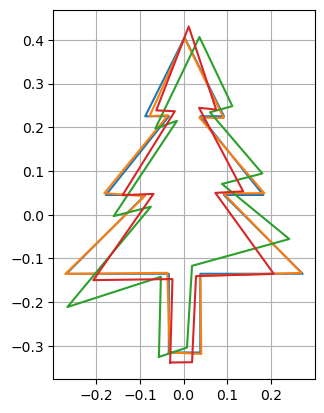

In [26]:
data = np.load('trees.npz')
aligned_trees = data['arr_1']

def plot_reshaped_trees(trees, title=""):
    for t in range(trees.shape[0]):
        plt.plot(trees[t, :16], trees[t, 16:])
    
    plt.title(title)
    plt.axis("scaled")
    plt.grid(True)
    plt.show()

plot_reshaped_trees(aligned_trees)

b) Berechnet eine Hauptkomponentenanalyse der ausgerichteten Formen. Wie viele Komponenten benötigt man, um 98% der totalen Varianz abzudecken? (4P)  
_Tipp:_ Hierzu könnt Ihr die Implementierung in `sklearn.decomposition.PCA` nutzen.

_Lösung:_

In [34]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(aligned_trees)

cumulative_variance_ratios = np.cumsum(pca.explained_variance_ratio_)
components_needed = np.argmax(cumulative_variance_ratios >= 0.98) + 1

print(f"Relative Varianzen: {pca.explained_variance_ratio_}")
print(f"Kumulative relative Varianzen: {cumulative_variance_ratios}")
print(f"Benötigte Komponenten: {components_needed}")

Relative Varianzen: [6.09842337e-01 3.85444610e-01 4.71305332e-03 3.15727425e-31]
Kumulative relative Varianzen: [0.60984234 0.99528695 1.         1.        ]
Benötigte Komponenten: 2


c) Visualisiert die Deformation in der ersten Hauptkomponente, indem ihr $\pm3\sqrt{\lambda_1}$ mal der ersten Hauptkomponente auf die Referenz addiert. (4P)  
_Tipp:_ Die Eigenwerte speichert scikit-learn in `explained_variance_`.

_Lösung:_

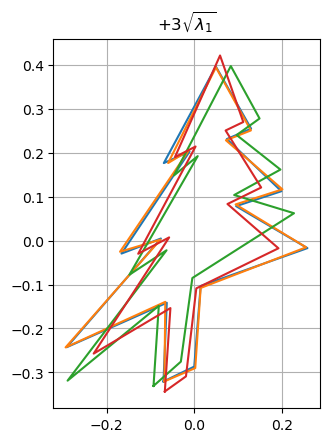

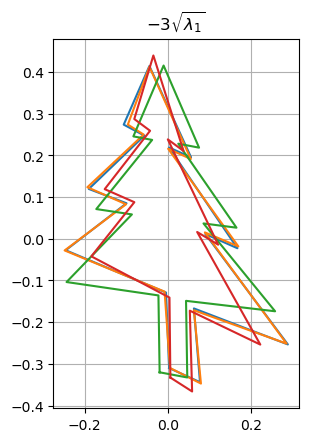

In [32]:
deformed_1 = aligned_trees + 3 * np.sqrt(pca.explained_variance_[0]) * pca.components_[0]
deformed_2 = aligned_trees - 3 * np.sqrt(pca.explained_variance_[0]) * pca.components_[0]

plot_reshaped_trees(deformed_1, "$ +3 \\sqrt{ \\lambda_1 } $")
plot_reshaped_trees(deformed_2, "$ -3 \\sqrt{ \\lambda_1 } $")

### Aufgabe 3 (Visuelle Bewertung von Multi-Modaler Registrierung, 10 Punkte)

<table><tr>
<td> <img src="CT.png" alt="Pelvic MRT" style="width: 100%;"/> </td>
<td> <img src="MRT.png" alt="Pelvic CT" style="width: 100%;"/> </td>
</tr></table>

In dieser Aufgabe geht es um die visuelle Evaluierung der Registrierung zweier medizinischer Bilddaten unterschiedlicher Modalitäten (CT und MRT), konkret aus dem Beckenbereich. Schaut euch hierzu die zwei nicht perfekt registrierten Bilder ```CT.png``` und ```MRT.png``` an. Ziel ist es, verschiedene Visualisierungsansätze zu implementieren, die euch helfen, etwaige Ungenauigkeiten in der Registrierung besser wahrzunehmen.

&nbsp;  
a) Implementiert eine Funktion, die die beiden Bilder in unterschiedlichen Farbkanälen übereinander legt (z.B. MRT in rot, CT in grün). Um später besser bewerten zu können, welche Konfigurationen euch am besten helfen, Registrierungsfehler zu erkennen, soll die Funktion die Farbkanalzuweisung als Argument übergeben bekommen. (3P)

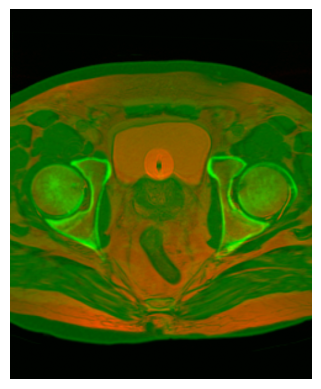

In [6]:
# Lösung
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski

ct = ski.io.imread('CT.png', as_gray=True)
mrt = ski.io.imread('MRT.png', as_gray=True)

def layer_images(img1, img2, channel1, channel2):
    # Channels: 0 -> red, 1 -> green, 2 -> blue
    h, w = img1.shape
    layered = np.zeros((h, w, 3), dtype=float)

    layered[..., channel1] = img1
    layered[..., channel2] = img2

    return layered

layered = layer_images(mrt, ct, 0, 1)

plt.imshow(layered)
plt.axis('off')
plt.show()

&nbsp;  
b) Implementiert nun eine Checkerboard-Visualisierung: Unterteilt das Ausgabebild in quadratische Patches, die abwechselnd aus dem MRT- und dem CT-Bild stammen. Der Patchgrößenparameter soll hierbei direkt an die Funktion übergeben werden, um verschieden große Checkerboards vergleichen zu können. Achtet dabei auf eine geeignete Handhabung von Randbereichen. (5P)

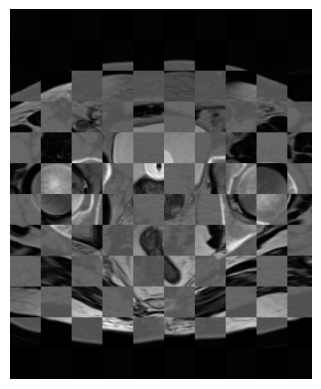

In [ ]:
def create_checkerboard(img1, img2, patch_size):
    checkerboard = np.zeros_like(img1)
    rows, cols = img1.shape
    for i in range(0, rows, patch_size):
        for j in range(0, cols, patch_size):
            if (i // patch_size + j // patch_size) % 2 == 0:
                checkerboard[i:i+patch_size, j:j+patch_size] = img1[i:i+patch_size, j:j+patch_size]
            else:
                checkerboard[i:i+patch_size, j:j+patch_size] = img2[i:i+patch_size, j:j+patch_size]
                
    return checkerboard

patch_size = 50
checkerboard = create_checkerboard(ct, mrt, patch_size)

plt.imshow(checkerboard, cmap='gray')
plt.axis('off')
plt.show()

&nbsp; 
c) Probiert verschiedene Farbkanalzuweisungen für die Überlagerung sowie unterschiedliche Patchgrößen für das Checkerboard aus. Welche Konfigurationen eignen sich eurer Meinung nach am besten, um die Registrierung qualitativ zu beurteilen? Begründet eure Wahl. (2P)

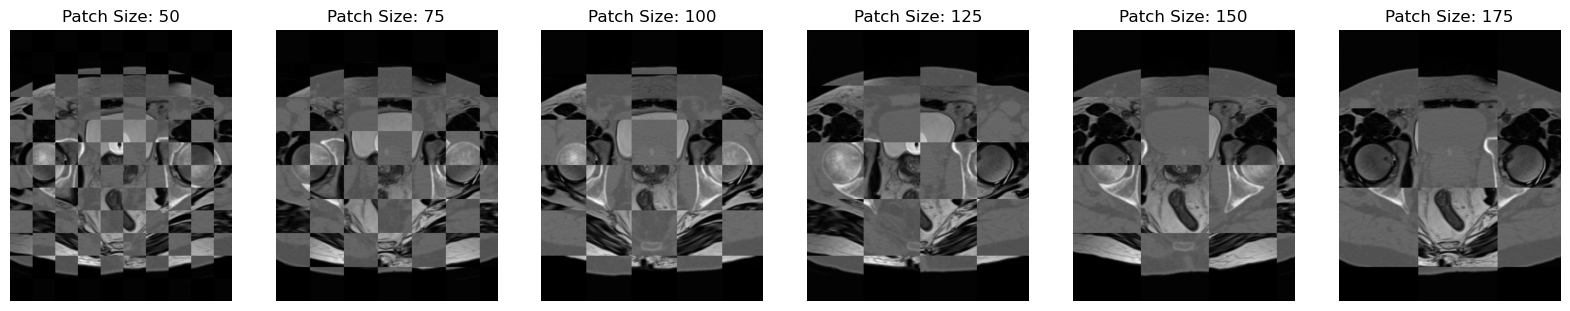

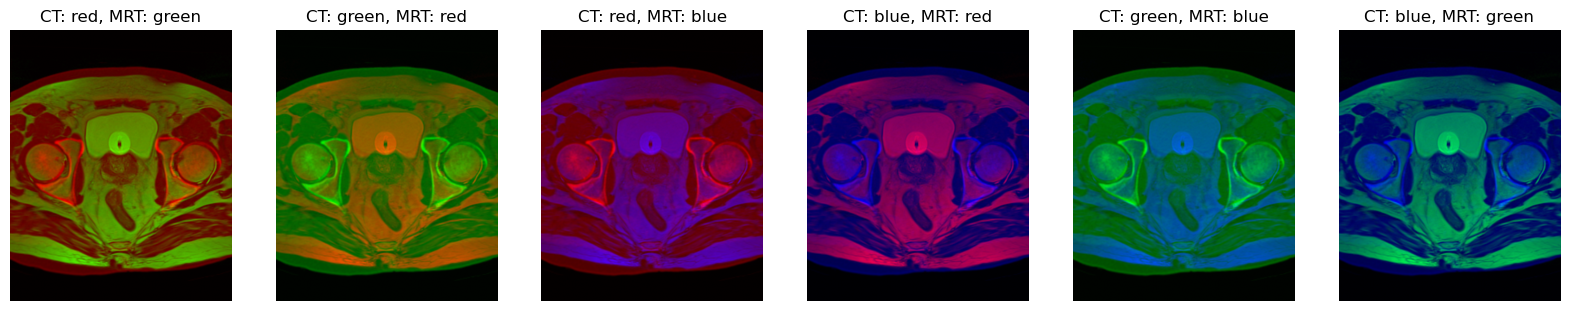

In [14]:
# Lösung
def test_patch_sizes(img1, img2):
    #patch_sizes = [16, 32, 64, 128, 256]
    patch_sizes = [50, 75, 100, 125, 150, 175]

    plt.figure(figsize=(20, 20))

    for i, patch_size in enumerate(patch_sizes):
        checkerboard = create_checkerboard(ct, mrt, patch_size)

        plt.subplot(1, len(patch_sizes), i + 1)
        plt.imshow(checkerboard, cmap='gray')
        plt.axis('off')
        plt.title(f'Patch Size: {patch_size}')

    plt.show()


color_dict = {0: 'red', 1: 'green', 2: 'blue'}

def test_color_combinations(img1, img2):
    color_combinations = [(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1)]

    plt.figure(figsize=(20, 20))

    for i, (c1, c2) in enumerate(color_combinations):
        rgb = layer_images(img1, img2, c1, c2)

        plt.subplot(1, len(color_combinations), i + 1)
        plt.imshow(rgb)
        plt.axis('off')
        plt.title(f'CT: {color_dict[c1]}, MRT: {color_dict[c2]}')

    plt.show()

test_patch_sizes(ct, mrt)
test_color_combinations(ct, mrt)

### Aufgabe 4 (Bild- und Weltkoordinatensysteme, 10 Punkte)
a) In Kapitel 5, Folie 31 haben wir mit xy- und rc-Koordinaten zwei verschiedene Konventionen für Bildkoordinatensysteme diskutiert. Schreibt eine Transformationsmatrix auf, mit der man in einem $640\times 480$ Pixel (Breite mal Höhe) großen Bild xy- in rc-Koordinaten umrechnen kann. Die Indizierung der Pixel soll dabei in beiden Fällen bei 0 beginnen. (5P)

_Lösung:_
$$ \text{Transformationsmatrix } T=
\begin{bmatrix}
0 & -1 & 479 \\
1 & 0 & 0 \\
0 & 0 & 1
\end{bmatrix},

\text{ Transformation: }
\begin{bmatrix} r \\ c \\ 1 \end{bmatrix} =
\begin{bmatrix}
0 & -1 & 479 \\
1 & 0 & 0 \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix} x \\ y \\ 1 \end{bmatrix}
$$

b) Folgende zwei MRT-Aufnahmen wurden in derselben Sitzung angefertigt und sind daher intrinsisch registriert: Ein $T_1$-gewichtetes Bild mit $256\times 256\times 220$ Voxeln der Kantenlänge 1mm sowie eine Reihe Diffusions-gewichteter Bilder mit $112\times 112\times 60$ Voxeln der Kantenlänge 2mm. In beiden Fällen sind die Achsen der Bild- und Weltkoordinatensysteme parallel zueinander. Bild- und Weltkoordinaten steigen außerdem in derselben Richtung an. In Weltkoordinaten liegt der Ursprung des $T_1$-Bildes bei $(-135,-110,-80)$, der Diffusions-gewichteten Bilder bei $(-120,-95,-30)$. Berechnet eine Transformationsmatrix um Bildkoordinaten im $T_1$-Bild in Bildkoordinaten im Diffusions-gewichteten Bild umzurechnen. (5P)  
_Tipp:_ Nutzt gern Python zur Matrixinvertierung.

_Lösung:_ Die Transformationsmatrix verschiebt zuerst die Bildkoordinaten des $T_1$-gewichteten Bildes in den Weltraum, dann werden die Koordinaten mit dem Faktor 2 skaliert, da die Voxel im Diffusions-gewichteten Bild 2mm lang sind, und schließlich werden die Koordiaten in den zweiten Bildraum verschoben:

\begin{equation*}
T = \begin{bmatrix}
1 & 0 & 0 & 120 \\
0 & 1 & 0 & 95 \\
0 & 0 & 1 & 30 \\
0 & 0 & 0 & 1
\end{bmatrix}
\cdot
\begin{bmatrix}
2 & 0 & 0 & 0 \\
0 & 2 & 0 & 0 \\
0 & 0 & 2 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
\cdot
\begin{bmatrix}
1 & 0 & 0 & -135 \\
0 & 1 & 0 & -110 \\
0 & 0 & 1 & -80 \\
0 & 0 & 0 & 1
\end{bmatrix}
= \begin{bmatrix}
2 & 0 & 0 & -150 \\
0 & 2 & 0 & -125 \\
0 & 0 & 2 & -130 \\
0 & 0 & 0 & 1
\end{bmatrix}
\end{equation*}